In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

from vuong_tests import *

In [2]:
#generate the sample
def gen_data():
    nobs = 1000
    beta = 3
    x = np.random.uniform(low=-1., high=1., size=nobs)
    e = np.random.uniform(low=-1., high=1., size=nobs) #np.random.normal(loc=0.0, scale=1.0, size=nobs) #
    y = 1*(1 + beta * x + e >= 0) 
    return y,x,nobs

In [3]:
def compute_llr(yn,xn):
    
    model1 = sm.Probit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    
    model2 = sm.Logit(yn,sm.add_constant(xn))
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    
    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)


yn,xn,nobs = gen_data()
print(compute_llr(yn,xn))

(2.7032932031946473, 0.015411712355936674)


1
1


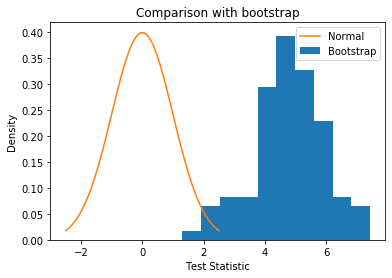

In [4]:
def regular_test(yn,xn,nobs,hist=False):
    llr, omega = compute_llr(yn,xn)
    test_stat = llr/(omega*np.sqrt(nobs))
    #plot
    if hist:
        x = np.linspace(-2.5, 2.5, 100)
        plt.plot(x, stats.norm.pdf(x, 0, 1),label="Normal")
    
    return 1*(test_stat >= 1.96) + 2*( test_stat <= -1.96)


def bootstrap_test(yn,xn,nobs,hist=False):
    test_stats = []
    trials = 100
    for i in range(trials):
        subn = 1000
        np.random.seed()
        sample  = np.random.choice(np.arange(0,nobs),subn,replace=True)
        ys,xs = yn[sample],xn[sample]
        llr, omega = compute_llr(ys,xs)
        test_stat = llr/(omega*np.sqrt(subn))
        test_stats.append(test_stat)
        
    llr, omega = compute_llr(yn,xn)
    test_stat = llr/(omega*np.sqrt(nobs))
    
    #plot
    if hist:
        plt.hist( 2*test_stat - test_stats, density=True,bins=10, label="Bootstrap")
    
    cv_lower = 2*test_stat - np.percentile(test_stats, 97.5, axis=0)
    cv_upper = 2*test_stat -  np.percentile(test_stats, 2.5, axis=0)
    return  2*(0 >= cv_upper) + 1*(0 <= cv_lower)
    

yn,xn,nobs = gen_data()
print(bootstrap_test(yn,xn,nobs,hist=True))
print(regular_test(yn,xn,nobs,hist=True))

plt.title("Comparison with bootstrap")
plt.xlabel("Test Statistic")
plt.ylabel("Density")
plt.legend()
plt.savefig('figs/bootstrap_compare1')
plt.show()


In [5]:
reg = np.array([0, 0 ,0])
boot = np.array([0, 0 ,0])
omega = 0
llr = 0
total = 1000
for i in range(total):
    np.random.seed()
    yn,xn,nobs = gen_data()
    llrn,omegan = compute_llr(yn,xn)
    
    #update the llr
    llr = llr +llrn
    omega = omega +omegan
    reg_index = regular_test(yn,xn,nobs)
    
    #update test results
    boot_index = bootstrap_test(yn,xn,nobs)
    reg[reg_index] = reg[reg_index] + 1
    boot[boot_index] = boot[boot_index] + 1

print("reg: %s, boot: %s, llr:%s, omega:%s"%(reg/total,boot/total,llr/total,omega/total))

reg: [0.003 0.997 0.   ], boot: [0.017 0.983 0.   ], llr:2.677881131428181, omega:0.015645737393878697


In [6]:
#Dgp1 -  reg: [0.737 0.263 0.   ], boot: [0.88  0.114 0.006], llr:0.7785740338656467, omega:0.02975939594282737
#dgp2  - reg: [0.756 0.242 0.002], boot: [0.839 0.152 0.009], llr:0.47658608905951694, omega:0.020173926657762808
#dgp3 - [0.003 0.997 0.   ], boot: [0.017 0.983 0.   ], llr:2.677881131428181, omega:0.015645737393878697